# Crating and exploring video data sets with using Youtube API

## Introduction: 
Youtube is a well-known platform which enables watching, commenting, posting and streaming videos online. It is estimated that around 800 milion videos have been posted there since its creation in 2005. Over the years, many myths and theories have evolved on how the youtube algorithm  works. For the new youtube content creators, it may be challenging to understand the nature of it. There are many speculations, what the key to success is to become a successful creator on youtube. Is it a number of likes and comments? Or is it the time when a video was posted? 

In my small project with use of Youtube API I would like to get some insights from this topic, in order to answer some questions which may be helpful to other people who just started their youtube adventure. I decided to focus mainly on the channels related to my interests which are fashion, history and travelling. 

### Aims of the project:
I would like to explore the following steps in this project:
- Getting to know how to obtain the data using Youtube API 
- Analyse common theories about what makes a video popular on youtube service (for each niche):
  - Does the number of likes matter for a video to be more popular?
  - Does the number of comments matter for views?
  - Does the duration of video matter?
  - Does the day of the week and hour on which the video was posted matter for the number of views?
- Compare the results of analysis for each field

### Steps of the project: 
1. Obtain youtube video data from channels in every niche. 
2. Preprocess the data.
3. Exploratory Data Analysis.
4. Conclusions.

### Informations about data: 
Since the project is manly focued on my personal youtube preferences, I was not able to find any proper datasets online which I could use in this project. I found only one data set on kaggle with top 200 youtube videos, but as I mentioned before, I would like to concentrate on fashion, history and travelling related videos. 

### Limitations of the data:
The selection of channels I included in my project is only based on my knowledge of the channels in these niches. I chose only 5 channels from each field, based on my personal preferences which may not reflect the nature of youtube. There are other metrics which can be taken into consideration in creating simmilar project, f. e. number of subscribes, views, existence of the channel. Moreover, there is plenty of channels on youtube from this fields, also smaller ones, which were not included in this project. 

### Ethics of data:
Usage of Youtube API is free of charge when your application sends requests without certain quota limit: 

"The YouTube Data API uses a quota to ensure that developers use the service as intended and do not create applications that unfairly reduce service quality or limit access for others. " 

The default quota limit is 10,000 units per day. One can reqest additional quota by filling up a form to Youtube API Services, if the daily quota limit was reached.
All data reqested by Youtube API is public data, there is no special privacy issues. Adittionaly, the data sets were obtained only for this research portfolio project and not for any commercial interests. 

In [1]:
# importing needed liblaries 
import pandas as pd 
import numpy as np 
from dateutil import parser
import isodate
from IPython.display import JSON

# getting goole API 
from googleapiclient.discovery import build

# getting visualisation liblaries 
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import seaborn as sns 
sns.set_style('darkgrid')

#### Creating data sets by using Youtube API:
The first step I took was creating a project on Google Developers Console. Everone who has google account can do this. Afterwards, I reqested API key (authorization credential), then I enabled Youtube API for my application. By doing this, I can send API requests to Youtube API services. As the next step, I checked and saved channels ID of each channel I wanted to include in this project. Finally, I created function which helped me get the channel statistics vie the API. 

Here was my personal api_key, but it has been removed before publishing this notebook due to safety issues. 

I saved all channel ids in the lists below: 

In [3]:
# getting channel ids of fashion channels 
fashion_channel_ids = ['UCU5Z-qPL8Terv_te68esHOw', # loic prigent - personally my favourite 
               'UC4zz6D7V2q5DtmwItWxui5Q', # understitch
               'UC1OR9yjgsvoFK3xxhCs-19Q', # bliss foster
               'UCkwYBK5LnMVYNNkl0C39IYA', # threaducation
               'UCoEj4uRzynPXEEegNqMnJVw' # hautelemode
              ]

In [4]:
# getting channel ids of history channels 
history_channel_ids = ['UCNIuvl7V8zACPpTmmNIqP2A', # oversimplified
                       'UCc-N24Y5OA0gqbjBwe1ttfA', # weird history 
                       'UCcgaO0y7vJVFl6xsAEA6Mog', # Oblicza XX wieku (polish one)
                       'UCngze_3Nx9sogT_oA3GvCdQ', # Historia w 5 minut (another polish one),
                       'UCuCuEKq1xuRA0dFQj1qg9-Q' # Knowledgia
                       ]

In [5]:
# getting channel ids of travelling channels 
travelling_channel_ids = ['UCvK4bOhULCpmLabd2pDMtnA', # Yes Theory
                          'UCre8_q4wMsG1k72HvGaRcdw', # Planeta Abstrakcja (polish one)
                          'UCLsnJt_eyqkGZ4ZEM__xCOg', # Vlog Casha (polish one)
                          'UCNu7GSRF7Y10OIWHQHpAx1g', # Bez Planu (another polish one)
                          'UCxDZs_ltFFvn0FDHT6kmoXA' # Bald and bankrupt
                          ]

In [6]:
api_service_name = "youtube"
api_version = "v3"

# get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key) # developer key was set to my own api key which was hidden in order to prevent using it by other people 

In [7]:
# create a function which gets us statistics of a channel 
def get_channel_statistics(youtube, channel_ids):
    
    all_data = [] 
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()
    
    #loop through items
    
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return pd.DataFrame(all_data)

# creating a function which gets video ids 
def get_video_ids(youtube,playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
            part="snippet,contentDetails",
            playlistId=playlist_id,
            maxResults = 50
    )
    response = request.execute()
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids

# creating a function which gets details of videos 
def get_video_details(youtube, video_ids):
    
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
        
        return pd.DataFrame(all_video_info)

### Get channel statistics: 
Using a function **get_channel_statistics** created above, we can get information about channels. 

In [8]:
fashion_data= get_channel_statistics(youtube, fashion_channel_ids)

In [9]:
fashion_data

,channelName,subscribers,views,totalVideos,playlistId
0,Loic Prigent,526000,82502958,194,UUU5Z-qPL8Terv_te68esHOw
1,"understitch,",15700,495987,22,UU4zz6D7V2q5DtmwItWxui5Q
2,Threaducation,167000,7315589,41,UUkwYBK5LnMVYNNkl0C39IYA
3,HauteLeMode,761000,144299140,610,UUoEj4uRzynPXEEegNqMnJVw
4,Bliss Foster,188000,10072998,175,UU1OR9yjgsvoFK3xxhCs-19Q


Let's check the datatypes in our dataset:

In [10]:
fashion_data.dtypes

channelName    object
subscribers    object
views          object
totalVideos    object
playlistId     object
dtype: object

I noticed that **subscribers, views, and totalVideos** columns have string data type, so I will change the data type to numeric one, which will allow me to perform visualisation and mathematical operations. 

In [11]:
# converting the numeric columns to proper data type 
numeric_columns = ['subscribers', 'views', 'totalVideos']
fashion_data[numeric_columns] = fashion_data[numeric_columns].apply(pd.to_numeric, errors='coerce')

In [12]:
# getting information for each video
fashion_video_df = pd.DataFrame()

for c in fashion_data['channelName'].unique():
    playlist_id = fashion_data.loc[fashion_data['channelName']== c, 'playlistId'].iloc[0]
    video_ids = get_video_ids(youtube, playlist_id)
    
    # get video data
    video_data = get_video_details(youtube, video_ids)

    # append video data together 
    fashion_video_df = pd.concat([fashion_video_df, video_data], ignore_index=True)

In [13]:
fashion_video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,eYDKVEdahQ8,Loic Prigent,MOSCHINO: INFLATION BUT MAKE IT FUN! By Loic P...,SUBTITLES ARE AVAILABLE!!!\n\nMoschino is alwa...,"[Mode, fashion, Haute Couture, Loic Prigent, c...",2022-12-03T11:00:18Z,35909,1341,None,74,PT16M30S,hd,true
1,R7d-U8JJyPw,Loic Prigent,OUI OUI BAGUETTE AT SCHIAPARELLI! #shorts,#fashion #schiaparelli,None,2022-12-01T14:18:46Z,4158,195,None,7,PT48S,hd,false
2,9aYycJ3Sn1Y,Loic Prigent,JUSTE AVANT DE MONTER SUR SCÈNE AVEC ANGÈLE! #...,La vidéo en entier : https://youtu.be/PK0ltkB_...,None,2022-11-29T16:00:04Z,16751,682,None,8,PT1M,hd,false
3,1Ld4ErsDcWc,Loic Prigent,GCDS: SPONGEBOB ON THE RUNWAY!! By Loic Prigent,SUBTITLES ARE AVAILABLE!!!\n\nAre you ready ki...,"[Mode, fashion, Haute Couture, Loic Prigent, c...",2022-11-26T11:00:01Z,100607,1480,None,57,PT12M15S,hd,true
4,FUXcw3C6B-k,Loic Prigent,JACQUEMUS: LOLI BAHIA SE MARIE SUR LA LUNE! #s...,La célèbre mannequin Loli Bahia a défilé pour ...,None,2022-11-22T15:00:15Z,8635,397,None,3,PT52S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,who1-kptZzo,Bliss Foster,The Problem with Digital Fashion,Uncovering the issues with how we talk about t...,None,2022-04-04T15:01:12Z,33010,2426,None,170,PT9M16S,hd,false
209,E6ONNR2pSP4,Bliss Foster,What Actually Happened at Paris Fashion Week p...,Roundup of the first few days of Paris Fashion...,None,2022-03-28T15:08:57Z,91408,5100,None,314,PT22M26S,hd,false
210,4CeprvZ-szQ,Bliss Foster,A Tour of the Best Fashion Museum in the World...,"A tour of the Mode Museum in Antwerp, Belgium....",None,2022-03-21T15:28:44Z,15555,1130,None,66,PT15M17S,hd,false
211,Pe-SWBmC6t4,Bliss Foster,Margiela Collaborated With Playboy in the 2000...,Maison Martin Margiela runway show during Pari...,None,2022-03-14T16:00:11Z,11103,799,None,32,PT9M4S,hd,false


Looks like it worked out. Now I have to get the channel statistics for the history channels, as well as for the travelling ones using the same functionality. All the steps below are the same as above. 

In [14]:
# getting channel statistics for history channels 
history_data= get_channel_statistics(youtube, history_channel_ids)

In [15]:
history_data

,channelName,subscribers,views,totalVideos,playlistId
0,Historia w 5 minut,209000,27599124,75,UUngze_3Nx9sogT_oA3GvCdQ
1,Knowledgia,1310000,147110525,163,UUuCuEKq1xuRA0dFQj1qg9-Q
2,OverSimplified,6970000,927953118,29,UUNIuvl7V8zACPpTmmNIqP2A
3,Weird History,4020000,514666738,612,UUc-N24Y5OA0gqbjBwe1ttfA
4,Oblicza XX Wieku,182000,23344926,111,UUcgaO0y7vJVFl6xsAEA6Mog


In [16]:
history_data[numeric_columns] = history_data[numeric_columns].apply(pd.to_numeric, errors='coerce')

In [17]:
history_video_df = pd.DataFrame()

for c in history_data['channelName'].unique():
    playlist_id = history_data.loc[history_data['channelName']== c, 'playlistId'].iloc[0]
    video_ids = get_video_ids(youtube, playlist_id)
    
    # get video data
    video_data = get_video_details(youtube, video_ids)

    # append video data together 
    history_video_df = pd.concat([history_video_df, video_data], ignore_index=True)

In [18]:
history_video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,HnP2Y11FniY,Historia w 5 minut,Szwecja. Historia w Pigułce.,Patronite: https://patronite.pl/historiaw5minu...,"[szwecja, historia w 5 minut, historia w piguł...",2022-11-27T20:43:21Z,69683,4332,None,360,PT26M45S,hd,true
1,l47bRSF1MXY,Historia w 5 minut,Historia Polski wg Putina,Kup Surfshark VPN na https://surfshark.deals/h...,"[historia w 5 minut, historia, historia polski...",2022-10-28T18:48:26Z,602128,17835,None,3032,PT15M48S,hd,true
2,MD4qgrapY8Y,Historia w 5 minut,Czechy. Historia Czech w XX wieku.,Film dokumentalny zawiera nigdy niepublikowane...,"[historia w 5 minut, czechy, historia czech]",2022-10-10T15:00:12Z,152716,6354,None,908,PT1H9M55S,hd,false
3,RgjU7KNiNVw,Historia w 5 minut,Kosowo vs Serbia. Historia w Pigułce.,Patronite: https://patronite.pl/historiaw5minu...,"[edukacja, historia, serbia, albania, film dok...",2022-08-14T17:36:50Z,156077,5940,None,907,PT22M17S,hd,true
4,3kI0Bcp7UC8,Historia w 5 minut,Japonia 0 „Mroczne Widmo”. Historia XIX wieku.,Patronite: https://patronite.pl/historiaw5minu...,"[historia w 5 minut, japonia, japonia dokument...",2022-04-15T16:00:01Z,181211,7092,None,412,PT31M16S,hd,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,m58_Q1-QM-o,Oblicza XX Wieku,Jak Hitler zdobył władzę w Niemczech cz. 1,Zostań patronem kanału – https://patronite.pl/...,None,2021-01-08T21:36:33Z,214959,7230,None,351,PT27M9S,hd,false
225,L1czrZVFvBc,Oblicza XX Wieku,"Bitwa o Leningrad cz. 3 ""Przełamanie""",Zostań patronem kanału – https://patronite.pl/...,None,2020-12-13T22:29:22Z,253166,7042,None,421,PT37M55S,hd,false
226,kZx3lCoVMYQ,Oblicza XX Wieku,"Bitwa o Leningrad cz. 2 ""Blokada""",Zostań patronem kanału – https://patronite.pl/...,None,2020-12-12T01:25:00Z,232025,6460,None,250,PT27M59S,hd,false
227,awct4aukQTQ,Oblicza XX Wieku,"Bitwa o Leningrad cz. 1 ""Inwazja""",Zostań patronem kanału – https://patronite.pl/...,None,2020-12-11T21:47:09Z,298703,8148,None,261,PT25M52S,hd,false


In [19]:
# repeat the same process for travelling channels 
travelling_data= get_channel_statistics(youtube, travelling_channel_ids)

In [20]:
travelling_data

,channelName,subscribers,views,totalVideos,playlistId
0,Planeta Abstrakcja,408000,44583636,88,UUre8_q4wMsG1k72HvGaRcdw
1,Vlog Casha,374000,65530199,409,UULsnJt_eyqkGZ4ZEM__xCOg
2,bald and bankrupt,3690000,540678656,242,UUxDZs_ltFFvn0FDHT6kmoXA
3,Yes Theory,8130000,963582860,367,UUvK4bOhULCpmLabd2pDMtnA
4,BezPlanu,555000,93861226,172,UUNu7GSRF7Y10OIWHQHpAx1g


In [21]:
travelling_data[numeric_columns] = travelling_data[numeric_columns].apply(pd.to_numeric, errors='coerce')

In [22]:
travelling_video_df = pd.DataFrame()

for c in travelling_data['channelName'].unique():
    playlist_id = travelling_data.loc[travelling_data['channelName']== c, 'playlistId'].iloc[0]
    video_ids = get_video_ids(youtube, playlist_id)
    
    # get video data
    video_data = get_video_details(youtube, video_ids)

    # append video data together 
    travelling_video_df = pd.concat([travelling_video_df, video_data], ignore_index=True)

In [23]:
travelling_video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,Q1MTY8GZvEw,Planeta Abstrakcja,Piechotą przez wiejską Hiszpanię,"Santiago de Compostela - to miejscowość, do kt...",None,2022-11-25T17:04:59Z,132807,7565,None,494,PT27M37S,hd,false
1,x6BfwHoszoA,Planeta Abstrakcja,Wyspa Lemurów - Madagaskar,"Madagaskar to kraj, który kojarzy się z lemura...",None,2022-11-19T09:01:44Z,144339,8380,None,456,PT25M9S,hd,false
2,Tb3VEczFZI8,Planeta Abstrakcja,Noc na Afrykańskim SOR,Spędziliśmy noc w szpitalu na Madagaskarze. Ot...,None,2022-11-11T16:00:28Z,242792,10819,None,819,PT22M6S,hd,false
3,55D71sljZMw,Planeta Abstrakcja,Tutaj miała być POLSKA KOLONIA,W okresie międzywojennym Polska miała plany ko...,None,2022-11-05T08:25:10Z,270249,9870,None,796,PT37M2S,hd,false
4,FubYTRBC9bc,Planeta Abstrakcja,Wyciąganie zmarłych z grobu na imprezę,Na Madagaskarze co 7 lat wyjmuje się zmarłych ...,None,2022-10-29T06:00:06Z,149385,6424,None,573,PT24M47S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,n2RIoOXztps,BezPlanu,"Tu była ""zielona"" stolica Europy - Lazarat",Polak w Albanii: https://bit.ly/3cYgl3o\n(wspo...,"[4k, polacy, saranda, colombia, bez planu, bus...",2020-10-25T10:10:58Z,373785,10249,None,502,PT23M31S,hd,true
246,k8qHJFO-rFo,BezPlanu,Odcinek o niczym. No dobra: posprzątałem plażę,Wspomniany odcinek z kanału Polak w Albanii:\n...,"[podrozowanie, lato, tavelling, market, south,...",2020-10-18T07:49:39Z,214274,8781,None,453,PT13M14S,hd,true
247,MKlTjAkBZN4,BezPlanu,Fenomen przyrodniczy w Albanii - Blue Eye,Polak w Albanii:\nhttps://www.youtube.com/chan...,"[kulinaria, bezplanu, vlog wakacje, ceny, trav...",2020-10-11T07:04:10Z,348339,10911,None,593,PT14M32S,hd,true
248,0oFQPu622BA,BezPlanu,Albańska prowincja [4K],Polak w Albanii:\nhttps://www.youtube.com/chan...,"[kuchnia, southern, saranda, goodweather, buse...",2020-10-04T08:07:11Z,346726,10519,None,614,PT22M45S,hd,true


### Preprocessing and feature engineering:

Check empty values in every data set:

In [24]:
fashion_video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount       True
duration          False
definition        False
caption           False
dtype: bool

In [25]:
history_video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount       True
duration          False
definition        False
caption           False
dtype: bool

In [26]:
travelling_video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount       True
duration          False
definition        False
caption           False
dtype: bool

As we can see, there are some similarities in missing values, mainly in **tags, favouriteCount, commentCount** columns, but there is nothing special in it. It is not surprising that some videos do not have tags, nor comments from the users, so I will move on to the next step. 

#### Check if data types of each column in datasets are correct:

In [27]:
fashion_video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [28]:
history_video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [29]:
travelling_video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

Unfortunately, not all columns have correct data types. All '-Count' columns are in string format. I will convert them to float type.

In [30]:
# change the column data types to desired ones 
numeric_col = ['viewCount','likeCount','favouriteCount','commentCount']
fashion_video_df[numeric_col] = fashion_video_df[numeric_col].apply(pd.to_numeric,errors = 'coerce',axis=1)

In [31]:
fashion_video_df.dtypes

video_id           object
channelTitle       object
title              object
description        object
tags               object
publishedAt        object
viewCount         float64
likeCount         float64
favouriteCount    float64
commentCount      float64
duration           object
definition         object
caption            object
dtype: object

In [32]:
#repeat same process for history channels data and travelling channels data 
history_video_df[numeric_col] = history_video_df[numeric_col].apply(pd.to_numeric,errors = 'coerce',axis=1)
travelling_video_df[numeric_col] = travelling_video_df[numeric_col].apply(pd.to_numeric,errors = 'coerce',axis=1)

In [33]:
history_video_df.dtypes

video_id           object
channelTitle       object
title              object
description        object
tags               object
publishedAt        object
viewCount         float64
likeCount         float64
favouriteCount    float64
commentCount      float64
duration           object
definition         object
caption            object
dtype: object

In [34]:
travelling_video_df.dtypes

video_id           object
channelTitle       object
title              object
description        object
tags               object
publishedAt        object
viewCount         float64
likeCount         float64
favouriteCount    float64
commentCount      float64
duration           object
definition         object
caption            object
dtype: object

## Enriching data by creating new colums:
In this process, I will create new columns which can be helpful in further analysis and may allow me to get more insights of the data sets:
- create 'publishedDayName' column by extracing days from existing 'publishedAt' column
- create 'publishedHour' column 
- convert duration of each video to seconds 
- get the number of tags for each video 
- get the length of title of each video 
- calcullate the ratio of comments and likes per 1000 views 

In [35]:
# create new column with name of a day when video was posted 
fashion_video_df['publishedAt'] =  fashion_video_df['publishedAt'].apply(lambda x: parser.parse(x))
fashion_video_df['publishedDayName'] = fashion_video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

In [36]:
# create new column with hour on which video was posted 
fashion_video_df['publishedHour'] = fashion_video_df['publishedAt'].apply(lambda x: x.hour)

In [37]:
# create new column with duration (in seconds) of video
fashion_video_df['durationSec'] = fashion_video_df['duration'].apply(lambda x: isodate.parse_duration(x))
fashion_video_df['durationSec'] = fashion_video_df['durationSec'].astype('timedelta64[s]')

In [38]:
# lets check if it worked 
fashion_video_df[['duration','durationSec']]

,duration,durationSec
0,PT16M30S,990.0
1,PT48S,48.0
2,PT1M,60.0
3,PT12M15S,735.0
4,PT52S,52.0
...,...,...
208,PT9M16S,556.0
209,PT22M26S,1346.0
210,PT15M17S,917.0
211,PT9M4S,544.0


In [39]:
# create column with tag count
fashion_video_df['tagCount'] = fashion_video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [40]:
# create column with length of title
fashion_video_df['titleLength'] = fashion_video_df['title'].apply(lambda x: len(x))

In [41]:
# create two new columns with like ratio and comments ratio 
fashion_video_df['likeRatio'] = fashion_video_df['likeCount']/ fashion_video_df['viewCount'] * 1000
fashion_video_df['commentRatio'] = fashion_video_df['commentCount']/ fashion_video_df['viewCount'] * 1000

Let us have a look at our enriched data set

In [42]:
fashion_video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishedDayName,publishedHour,durationSec,tagCount,titleLength,likeRatio,commentRatio
0,eYDKVEdahQ8,Loic Prigent,MOSCHINO: INFLATION BUT MAKE IT FUN! By Loic P...,SUBTITLES ARE AVAILABLE!!!\n\nMoschino is alwa...,"[Mode, fashion, Haute Couture, Loic Prigent, c...",2022-12-03 11:00:18+00:00,35909.0,1341.0,NaN,74.0,PT16M30S,hd,true,Saturday,11,990.0,48,52,37.344398,2.060765
1,R7d-U8JJyPw,Loic Prigent,OUI OUI BAGUETTE AT SCHIAPARELLI! #shorts,#fashion #schiaparelli,None,2022-12-01 14:18:46+00:00,4158.0,195.0,NaN,7.0,PT48S,hd,false,Thursday,14,48.0,0,41,46.897547,1.683502
2,9aYycJ3Sn1Y,Loic Prigent,JUSTE AVANT DE MONTER SUR SCÈNE AVEC ANGÈLE! #...,La vidéo en entier : https://youtu.be/PK0ltkB_...,None,2022-11-29 16:00:04+00:00,16751.0,682.0,NaN,8.0,PT1M,hd,false,Tuesday,16,60.0,0,52,40.713987,0.477583
3,1Ld4ErsDcWc,Loic Prigent,GCDS: SPONGEBOB ON THE RUNWAY!! By Loic Prigent,SUBTITLES ARE AVAILABLE!!!\n\nAre you ready ki...,"[Mode, fashion, Haute Couture, Loic Prigent, c...",2022-11-26 11:00:01+00:00,100607.0,1480.0,NaN,57.0,PT12M15S,hd,true,Saturday,11,735.0,33,47,14.710706,0.566561
4,FUXcw3C6B-k,Loic Prigent,JACQUEMUS: LOLI BAHIA SE MARIE SUR LA LUNE! #s...,La célèbre mannequin Loli Bahia a défilé pour ...,None,2022-11-22 15:00:15+00:00,8635.0,397.0,NaN,3.0,PT52S,hd,false,Tuesday,15,52.0,0,51,45.975680,0.347423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,who1-kptZzo,Bliss Foster,The Problem with Digital Fashion,Uncovering the issues with how we talk about t...,None,2022-04-04 15:01:12+00:00,33010.0,2426.0,NaN,170.0,PT9M16S,hd,false,Monday,15,556.0,0,32,73.492881,5.149955
209,E6ONNR2pSP4,Bliss Foster,What Actually Happened at Paris Fashion Week p...,Roundup of the first few days of Paris Fashion...,None,2022-03-28 15:08:57+00:00,91408.0,5100.0,NaN,314.0,PT22M26S,hd,false,Monday,15,1346.0,0,51,55.793804,3.435148
210,4CeprvZ-szQ,Bliss Foster,A Tour of the Best Fashion Museum in the World...,"A tour of the Mode Museum in Antwerp, Belgium....",None,2022-03-21 15:28:44+00:00,15555.0,1130.0,NaN,66.0,PT15M17S,hd,false,Monday,15,917.0,0,66,72.645452,4.243009
211,Pe-SWBmC6t4,Bliss Foster,Margiela Collaborated With Playboy in the 2000...,Maison Martin Margiela runway show during Pari...,None,2022-03-14 16:00:11+00:00,11103.0,799.0,NaN,32.0,PT9M4S,hd,false,Monday,16,544.0,0,60,71.962533,2.882104


Looks great to me. I think I got everything what I needed in order to move to exploratory data analysis, but before doing so, I have to repeat the same process for other two data sets. 

In [43]:
# for history data set
# published day column
history_video_df['publishedAt'] =  history_video_df['publishedAt'].apply(lambda x: parser.parse(x))
history_video_df['publishedDayName'] = history_video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

# published hour column 
history_video_df['publishedHour'] = history_video_df['publishedAt'].apply(lambda x: x.hour)

# duration column
history_video_df['durationSec'] = history_video_df['duration'].apply(lambda x: isodate.parse_duration(x))
history_video_df['durationSec'] = history_video_df['durationSec'].astype('timedelta64[s]')

# tag count column
history_video_df['tagCount'] = history_video_df['tags'].apply(lambda x: 0 if x is None else len(x))

# title length
history_video_df['titleLength'] = history_video_df['title'].apply(lambda x: len(x))

# like and comment ratio columns 
history_video_df['likeRatio'] = history_video_df['likeCount']/ history_video_df['viewCount'] * 1000
history_video_df['commentRatio'] = history_video_df['commentCount']/ history_video_df['viewCount'] * 1000

In [44]:
# for travelling data set
# published day column
travelling_video_df['publishedAt'] =  travelling_video_df['publishedAt'].apply(lambda x: parser.parse(x))
travelling_video_df['publishedDayName'] = travelling_video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

# published hour column 
travelling_video_df['publishedHour'] = travelling_video_df['publishedAt'].apply(lambda x: x.hour)

# duration column
travelling_video_df['durationSec'] = travelling_video_df['duration'].apply(lambda x: isodate.parse_duration(x))
travelling_video_df['durationSec'] = travelling_video_df['durationSec'].astype('timedelta64[s]')

# tag count column
travelling_video_df['tagCount'] = travelling_video_df['tags'].apply(lambda x: 0 if x is None else len(x))

# title length
travelling_video_df['titleLength'] = travelling_video_df['title'].apply(lambda x: len(x))

# like and comment ratio columns 
travelling_video_df['likeRatio'] = travelling_video_df['likeCount']/ history_video_df['viewCount'] * 1000
travelling_video_df['commentRatio'] = travelling_video_df['commentCount']/ history_video_df['viewCount'] * 1000

## Get some extra info from data sets: 

In this part, I would like to get some extra information about each data set, just out of curiosity:
- what are the most popular videos in each field?
- which videos have the longest titles?
- which videos are the longes? 

Let's have a look at 5 of the most popular videos in each field:

In [45]:
fashion_video_df[['channelTitle','title','viewCount']].sort_values(by='viewCount',ascending=False).head(5)

,channelTitle,title,viewCount
37,Loic Prigent,"CELINE BOOMS! With Lisa 리사 , Taehyung 김태형 / V ...",4288122.0
156,HauteLeMode,Was Dua Lipa wrong for wearing a white dress t...,3175999.0
182,Bliss Foster,CONDOM HANDS???? on the runway at #parisfashio...,2351581.0
47,Loic Prigent,DIOR: ON VISITE L’INCROYABLE NOUVEAU MUSÉE AVA...,1653933.0
159,HauteLeMode,The Legendary Fashion Designer Issey Miyake Ha...,1144502.0


**Loic Prigent** wins this competition with his video about **CELINE fashion show** with around 4260000 views. 

In [46]:
history_video_df[['channelTitle','title','viewCount']].sort_values(by='viewCount',ascending=False).head(5)

,channelTitle,title,viewCount
122,OverSimplified,WW2 - OverSimplified (Part 1),78396962.0
116,OverSimplified,The Cold War - OverSimplified (Part 1),53985347.0
121,OverSimplified,WW2 - OverSimplified (Part 2),51373972.0
110,OverSimplified,The American Civil War - OverSimplified (Part 1),47096716.0
119,OverSimplified,The American Revolution - OverSimplified (Par...,46661710.0


Here it is clear that **OverSimplified** is the winner. What's more, 5 of the most viewed videos were published by this channel. 

In [47]:
travelling_video_df[['channelTitle','title','viewCount']].sort_values(by='viewCount',ascending=False).head(5)

,channelTitle,title,viewCount
196,Yes Theory,I Hitchhiked the World's Deadliest Train (20hr...,9550223.0
160,Yes Theory,Hunting Nepal’s Mad Honey That Makes You Hallu...,8226764.0
180,Yes Theory,I Spent a Day with Giants (World's Strongest Men),7544141.0
108,bald and bankrupt,Leaving Kyiv On A Refugee Train 🇺🇦,6787148.0
182,Yes Theory,50 Hours In A Country That Doesn't Exist On A ...,6367813.0


In travelling data set, **Yes Theory** has videos with the biggest total view count.

It will be also interesting to check the videos with the longest titles:

In [48]:
fashion_video_df[['channelTitle','title','titleLength']].sort_values(by='titleLength',ascending=False).head(5)

,channelTitle,title,titleLength
148,HauteLeMode,Fendi’s Baguette Bag had a 25th Anniversary th...,100
8,Loic Prigent,DIOR: LA SUBLIIIIIME COLLECTION DE KIM JONES! ...,100
172,Bliss Foster,Day 8 of Paris Fashion Week Runway Shows and C...,99
171,Bliss Foster,The FINAL DAY of Paris Fashion Week Runway Sho...,99
188,Bliss Foster,Is Fashion Superficial? Is Fashion Shallow? Is...,98


On the first place are ex aequo: **HauteLeMode** and **Loic Prigent**, with videos which had 100 characters. 

In [49]:
history_video_df[['channelTitle','title','titleLength']].sort_values(by='titleLength',ascending=False).head(5)

,channelTitle,title,titleLength
182,Oblicza XX Wieku,"Polski ""kocioł bałkański"" czy państwo perspekt...",97
201,Oblicza XX Wieku,J. Bartosiak i P. Zychowicz w rozmowie z B. Bo...,90
53,Knowledgia,How did Rome Expand into Greece and Hispania? ...,84
204,Oblicza XX Wieku,Sojusznicy Hitlera czy państwo neutralne - Szw...,83
178,Weird History,"TIMELINE 1972 - The Immaculate Reception, Nixo...",80


In history data set **Oblicza XX Wieku** channel posted a video with the longest title, which is 97 characters. 

In [50]:
travelling_video_df[['channelTitle','title','titleLength']].sort_values(by='titleLength',ascending=False).head(5)

,channelTitle,title,titleLength
82,Vlog Casha,Gruba akcja nocą na autostradzie. Wybuchła nam...,88
57,Vlog Casha,Tak wygląda pociąg pierwszej klasy w Indiach. ...,85
76,Vlog Casha,"Wkopaliśmy się w małe tarapaty, pomogli nam pr...",85
78,Vlog Casha,"""IDZIECIE TAM NA WŁASNĄ ODPOWIEDZIALNOŚĆ"", HIK...",84
95,Vlog Casha,Tak wygląda granica Meksyku i USA (El Paso - C...,82


There, **Vlog Casha posted** videos with the longest titles. 

Now let's have a look at the videos with the longest duration:

In [51]:
fashion_video_df[['channelTitle','title','durationSec']].sort_values(by='durationSec',ascending=False).head(5)

,channelTitle,title,durationSec
186,Bliss Foster,How to Learn Everything about Margiela - Part 2,8893.0
20,Loic Prigent,BALENCIAGA: CASTING OLYMPIQUE AVEC NICOLE KIDM...,2998.0
75,Threaducation,The Pharrell Williams Story,2663.0
84,Threaducation,The History of Raf Simons,2247.0
120,HauteLeMode,KIM KARDASHIAN WON AN INNOVATOR AWARD BUT HER ...,2176.0


In fashion video dataset, **Bliss Foster** posted a video which is almost 9000 seconds long, which is almost 3 hours long!

In [52]:
history_video_df[['channelTitle','title','durationSec']].sort_values(by='durationSec',ascending=False).head(5)

,channelTitle,title,durationSec
201,Oblicza XX Wieku,J. Bartosiak i P. Zychowicz w rozmowie z B. Bo...,4254.0
2,Historia w 5 minut,Czechy. Historia Czech w XX wieku.,4195.0
5,Historia w 5 minut,Japonia 1 „Nowa Nadzieja”. Historia XX wieku.,2844.0
197,Oblicza XX Wieku,Stracona szansa Ukrainy cz. 1 - 2004 Pomarańcz...,2657.0
220,Oblicza XX Wieku,Finlandia podczas II wojny światowej cz. 2 (19...,2535.0


**Oblicza XX Wieku** posted the longest video, but only around one minute shorter than **Historia w 5 Minut**. 

In [53]:
travelling_video_df[['channelTitle','title','durationSec']].sort_values(by='durationSec',ascending=False).head(5)

,channelTitle,title,durationSec
101,bald and bankrupt,Visiting The World's Most Dangerous Country 🇦🇫...,4349.0
231,BezPlanu,Tak wyglądały morza 300 lat temu - Tubbataha [4K],3731.0
103,bald and bankrupt,Solo Through Romania's Dark Past 🇷🇴,3046.0
107,bald and bankrupt,The Syria The Media Won't Show You 🇸🇾,3039.0
105,bald and bankrupt,This Is Britain! 🇬🇧 ( Nation of Madlads ),3010.0


Here, **bald and bankrupt** posted the longest videos. 

## Exploratory data analysis: 

First of all, let's create a ranking with the channels which have the biggest number of subsribers by making a simple barplot.

#### Fashion channels:

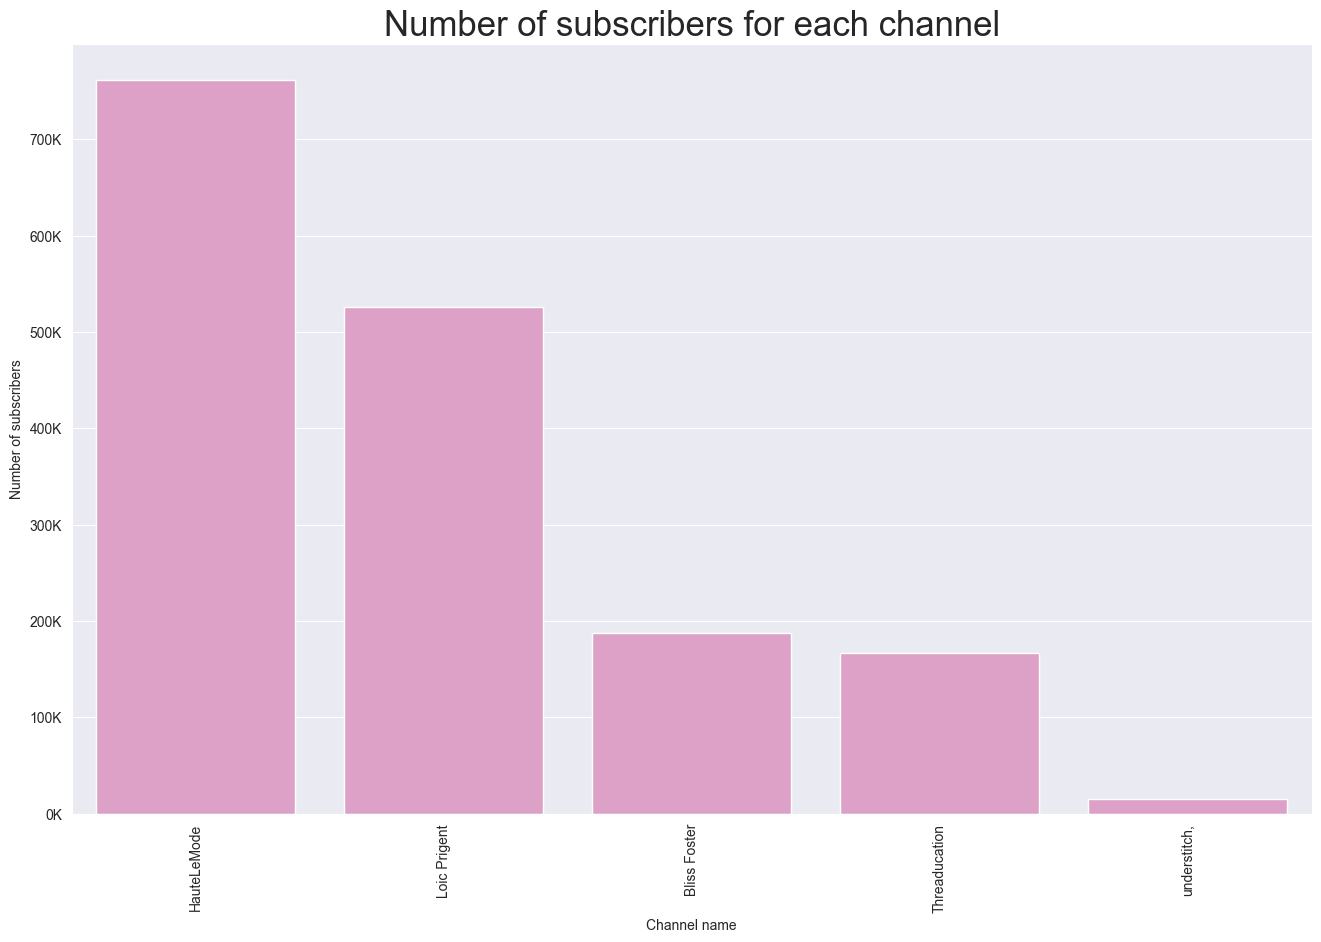

In [54]:
# subscribers per fashion channel
plt.figure(figsize=(16,10))
ax = sns.barplot(x='channelName', y='subscribers', data=fashion_data.sort_values('subscribers', ascending=False),
                 color='#E797cb')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
ax.set(xlabel='Channel name', ylabel='Number of subscribers')
ax.set_title('Number of subscribers for each channel',fontsize=25)
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

We can see on the plot above that **HauteLeMode** has the most of subsribers, with around 750 thousand subscribers. On the second place is **Loic Prigent** with over half of milion subscribers. Other fashon channels are not that popular, all of them have less than 200 thousand subscribers with understitch closing the ranking, with not more than 20 thousand subscribers. 

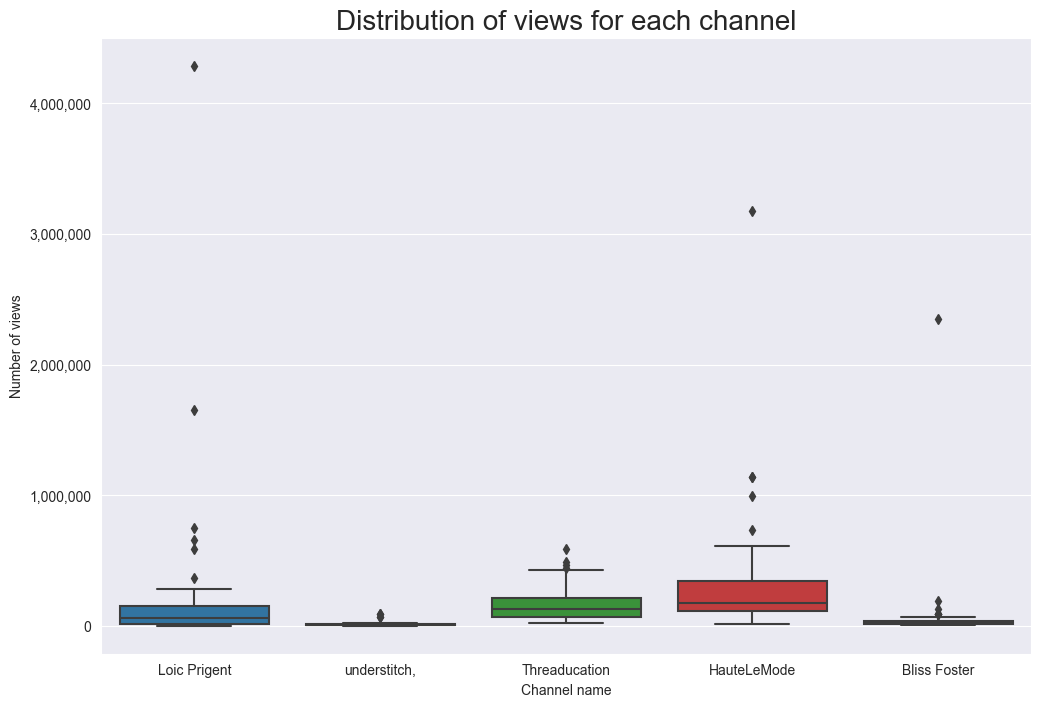

In [55]:
# distribution of views per fashion channel 
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='channelTitle',y='viewCount',data=fashion_video_df)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.set(xlabel='Channel name', ylabel='Number of views')
ax.set_title('Distribution of views for each channel',fontsize=20)
plt.show()

On this plot we can see that 3 out of 5 channels **(Threaducation, Loic Prigent and HauteLeMode)** have distibution of views within a range of half of milion. Understitch and Bliss Foster do not have that many subscribers, which means that they are less popular than the rest of them, which is why their videos got less views. However, there are some outliers which got way more views than the avarage is, f. e. **Loic Prigent** with over 4 milion views.

#### History channels: 

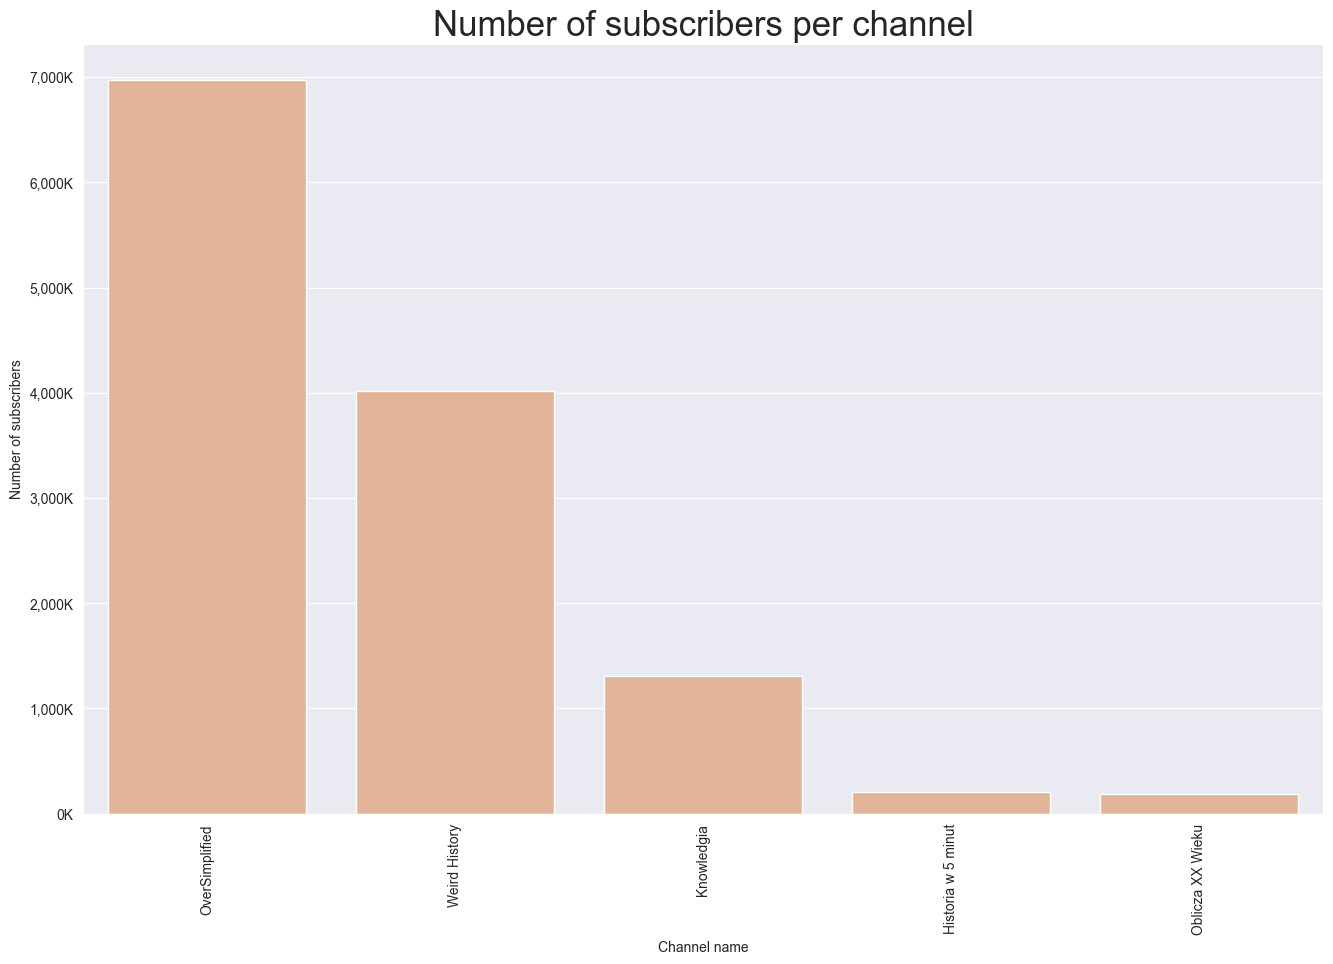

In [56]:
# for history channels 
plt.figure(figsize=(16,10))
ax = sns.barplot(x='channelName', y='subscribers', data=history_data.sort_values('subscribers', ascending=False),
                 color='#Edb08d')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
ax.set(xlabel='Channel name', ylabel='Number of subscribers')
ax.set_title('Number of subscribers per channel',fontsize=25)
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

**OverSimplified** and **Weird History** have the biggest number of subscribers, 7 milion and 4 milion accordingly. Polish channels **(Historia w 5 minut and Oblicza XX Wieku)** are not that popular in comparison to the other channels, but it is not surprising since it is a niche within a niche. Both of them are targeting the polish speaking audience, whereas the rest of them can reach people from all over the world. 

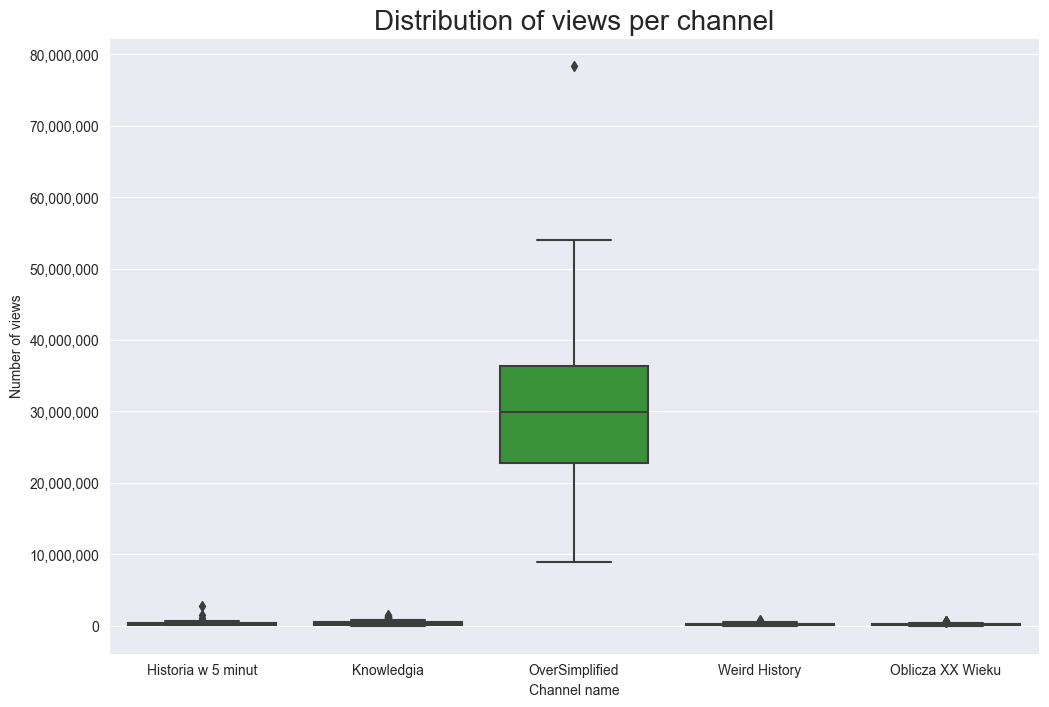

In [57]:
# history channels 
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='channelTitle',y='viewCount',data=history_video_df)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.set(xlabel='Channel name', ylabel='Number of views')
ax.set_title('Distribution of views per channel',fontsize=20)
plt.show()

With a number of views ranging from 10 to 55 milion, **OverSimplified** has the most popular videos. Moreover, some of his video got almost 80 milion views! That is impressive, given the fact that the other ones have an avarage of around 200000 views. 

#### Travelling channels: 

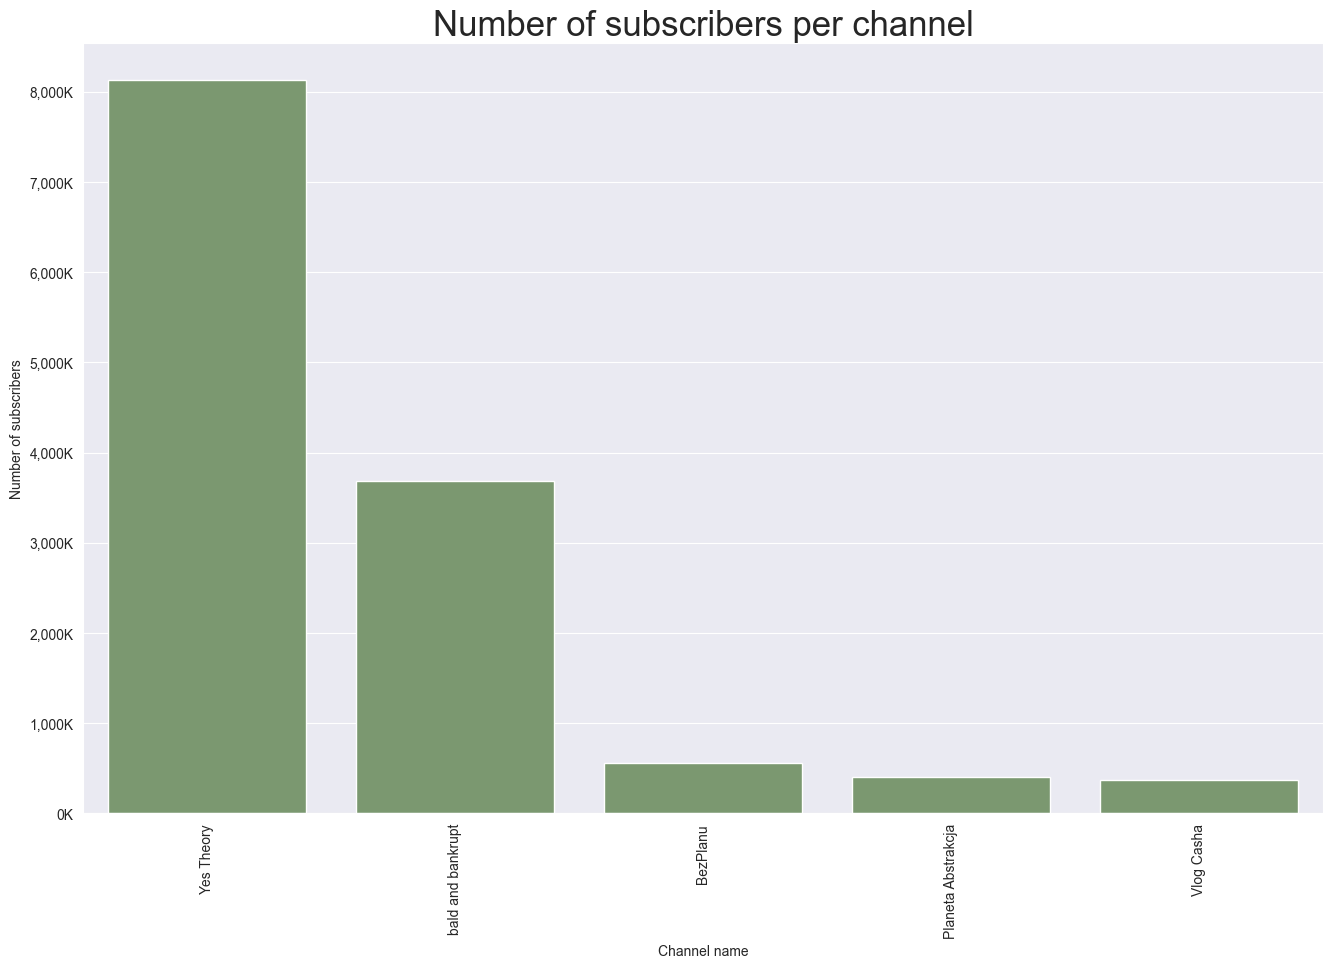

In [58]:
# travelling channels 
plt.figure(figsize=(16,10))
ax = sns.barplot(x='channelName', y='subscribers', data=travelling_data.sort_values('subscribers', ascending=False),
                color='#789f69')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
ax.set(xlabel='Channel name', ylabel='Number of subscribers')
ax.set_title('Number of subscribers per channel',fontsize=25)
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

**Yes Theory** and **bald and bankrupt** are way more popular than the other 3 channels, but here it is the same case as above: **BezPlanu, Planeta Abstrakcja and Vlog Casha** are polish channels, which may be the case why these channels have way less subscribers. **Yes Theory** is the most popular channel in this list, with over 8 milion subsribers. 

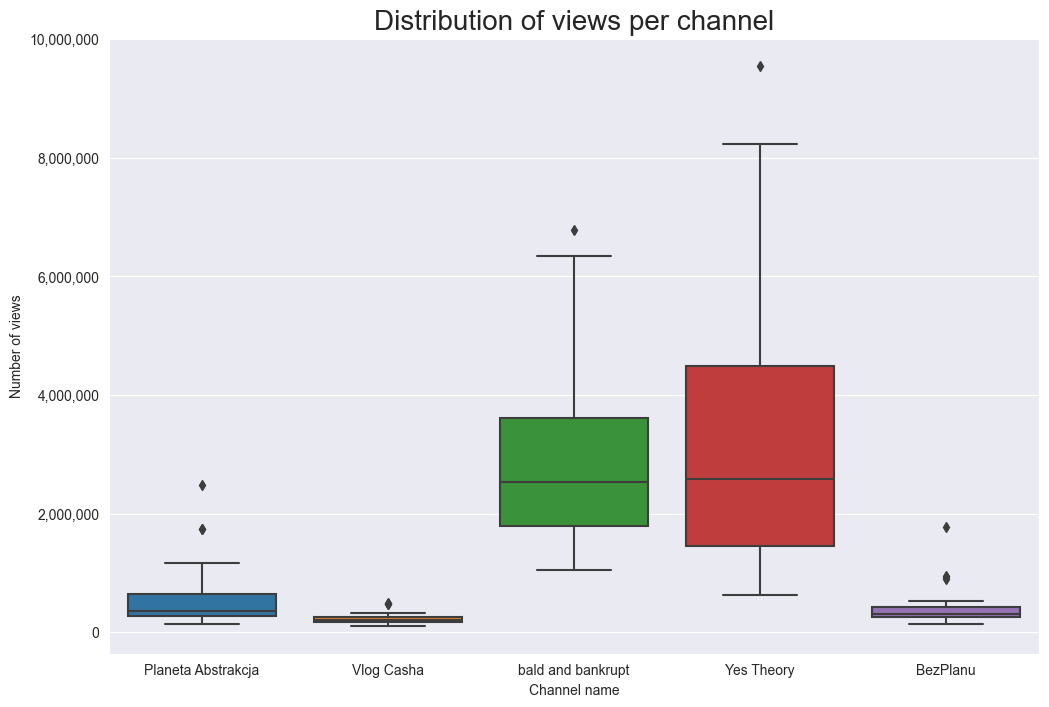

In [59]:
# travelling channels 
plt.figure(figsize=(12,8))
ax = sns.boxplot(x='channelTitle',y='viewCount',data=travelling_video_df)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.set(xlabel='Channel name', ylabel='Number of views')
ax.set_title('Distribution of views per channel',fontsize=20)
plt.show()

Here the distribution of views per channels is more interesting, with **Yes Theory** having the most popular videos, with video's views ranging from less than milion views (probably the old ones when this channel was not as popular as it is nowadays) to more than 8 milion views. The second place takes  **bald and bancrupt** with almost the same average view count as **Yes Theory**, which is somewhere around 2.5 milion views. 

#### Does the number of likes and comments correlate with the number of views? (fashion channels)

I would like to check if the number of comments and likes correlates with the number of views that the video gets. 

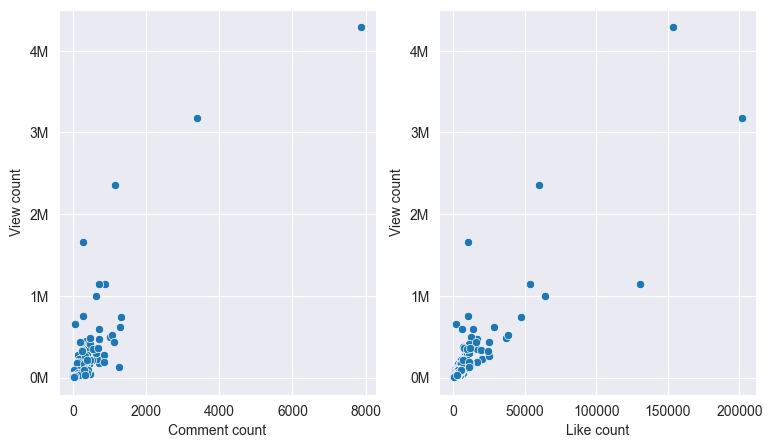

In [60]:
# fashion videos
fig, ax = plt.subplots(1,2,figsize=(9,5))

sns.scatterplot(data = fashion_video_df, x = "commentCount", y = "viewCount", ax=ax[0])
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000)+'M'))
ax[0].set(xlabel='Comment count', ylabel='View count')

sns.scatterplot(data = fashion_video_df, x = "likeCount", y = "viewCount", ax=ax[1])
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000)+'M'))
ax[1].set(xlabel='Like count', ylabel='View count')
plt.show()

It is easy to see that the number of comments and likes correlates with the number of views that a video got. 
On the other hand, the more people watch certain video, the more possible is that it gets more comments and likes. In order to exclude this factor, I will plot the same relationship using commentRatio and likeRatio columns.

#### Let us see the correlation between comment and like ratio for fashion channels

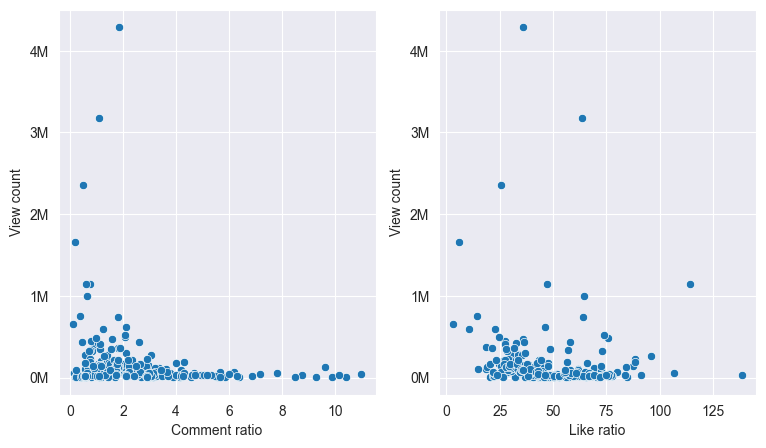

In [61]:
fig, ax = plt.subplots(1,2,figsize=(9,5))

sns.scatterplot(data = fashion_video_df, x = "commentRatio", y = "viewCount", ax=ax[0])
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000)+'M'))
ax[0].set(xlabel='Comment ratio', ylabel='View count')

sns.scatterplot(data = fashion_video_df, x = "likeRatio", y = "viewCount", ax=ax[1])
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000)+'M'))
ax[1].set(xlabel='Like ratio', ylabel='View count')
plt.show()

The correlation on the plots above is not as clear as in the previous case. The comment-view relationship dissapeared, there are some videos which got over 4 milion views, but very little comments, as well as the videos with a small number of views, and a lot of comments. The view-like correlation can still be seen, very subtle though. The reason behind this can be that writing a comment takes way more effort than clicking a like button. Also, the older the video is, the less relevant it becomes, which is why people may not want to leave a comment below a video. Moreover, there is a tendency for liking products and videos which are liked by many other people. 

Let's have a look at history and travelling data sets, and plot the relationship between comment count, like count, comment ratio, like ratio and view count

#### History channels:

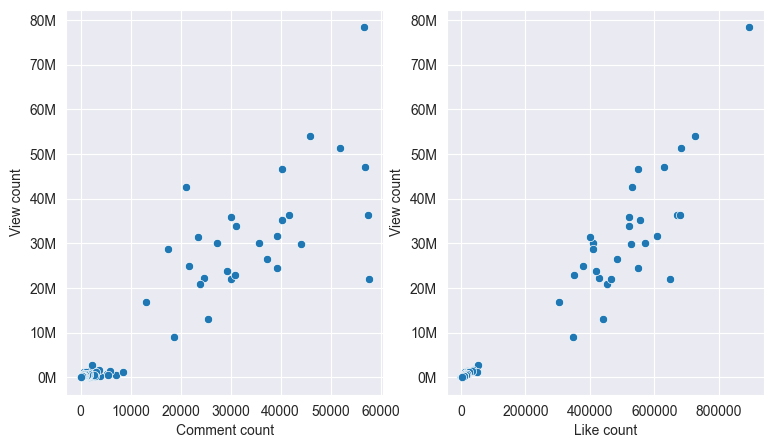

In [62]:
# history channels comment and like count
fig, ax = plt.subplots(1,2,figsize=(9,5))
sns.scatterplot(data = history_video_df, x = "commentCount", y = "viewCount", ax=ax[0])
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000)+'M'))
ax[0].set(xlabel='Comment count', ylabel='View count')

sns.scatterplot(data = history_video_df, x = "likeCount", y = "viewCount", ax=ax[1])
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000)+'M'))
ax[1].set(xlabel='Like count', ylabel='View count')
plt.show()

Plotting comment and like count against the view count shows that the correlation between these two is pretty visible. The more comments and likes video gets, the more views it becomes. Now, let's plot comment and like ratios against the view count. 

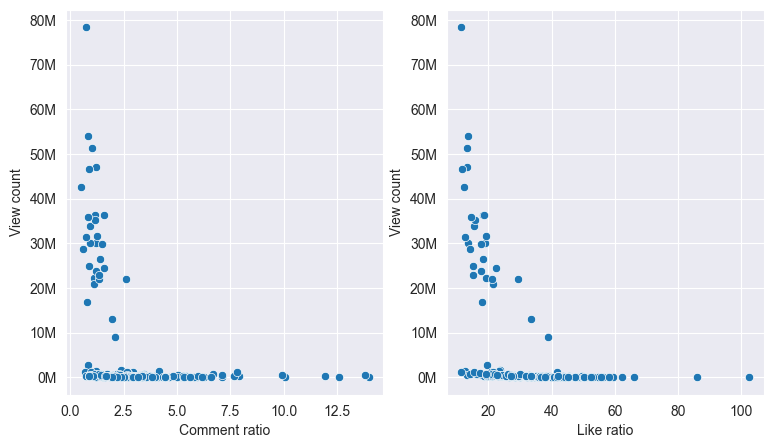

In [63]:
# history channels commen and likes ratios 
fig, ax = plt.subplots(1,2,figsize=(9,5))
sns.scatterplot(data = history_video_df, x = "commentRatio", y = "viewCount", ax=ax[0])
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000)+'M'))
ax[0].set(xlabel='Comment ratio', ylabel='View count')

sns.scatterplot(data = history_video_df, x = "likeRatio", y = "viewCount", ax=ax[1])
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000)+'M'))
ax[1].set(xlabel='Like ratio', ylabel='View count')
plt.show()

Here, the relationship between comment/like ratios and the view count is similar as in the previous example with fashion-related videos. The correlation does not seem to exist. 

#### Travelling channels:

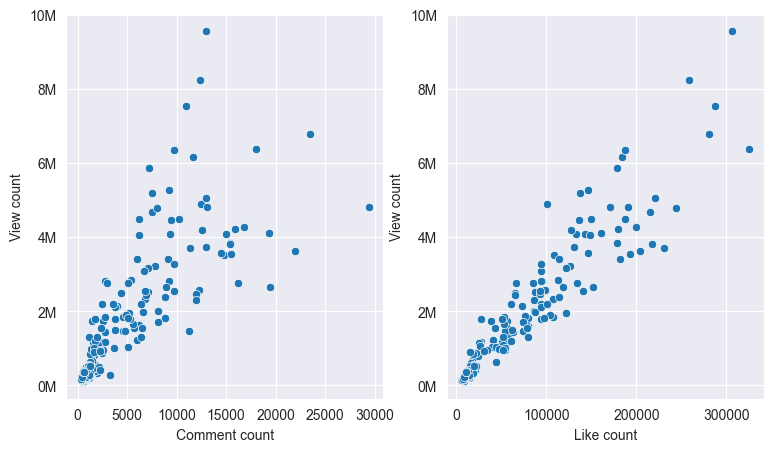

In [64]:
#travelling channels comment count and views
fig, ax = plt.subplots(1,2,figsize=(9,5))
sns.scatterplot(data = travelling_video_df, x = "commentCount", y = "viewCount", ax=ax[0])
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000)+'M'))
ax[0].set(xlabel='Comment count', ylabel='View count')

sns.scatterplot(data = travelling_video_df, x = "likeCount", y = "viewCount", ax=ax[1])
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000)+'M'))
ax[1].set(xlabel='Like count', ylabel='View count')
plt.show()

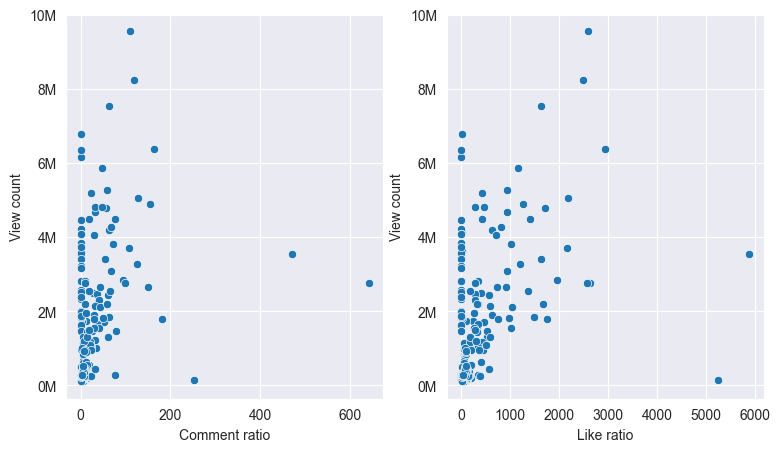

In [65]:
# comment and like ratios for travelling channels 
fig, ax = plt.subplots(1,2,figsize=(9,5))
sns.scatterplot(data = travelling_video_df, x = "commentRatio", y = "viewCount", ax=ax[0])
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000)+'M'))
ax[0].set(xlabel='Comment ratio', ylabel='View count')

sns.scatterplot(data = travelling_video_df, x = "likeRatio", y = "viewCount", ax=ax[1])
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000)+'M'))
ax[1].set(xlabel='Like ratio', ylabel='View count')
plt.show()

In this case, as well as in two previous ones, the correlation between comment/like count and view count is visible. The correlation between comment/like ratios and view count is not clear, however, it can be noticed that there is a very subtle correlation in this case. 

#### Does the number of tags matter for a video to get more views?

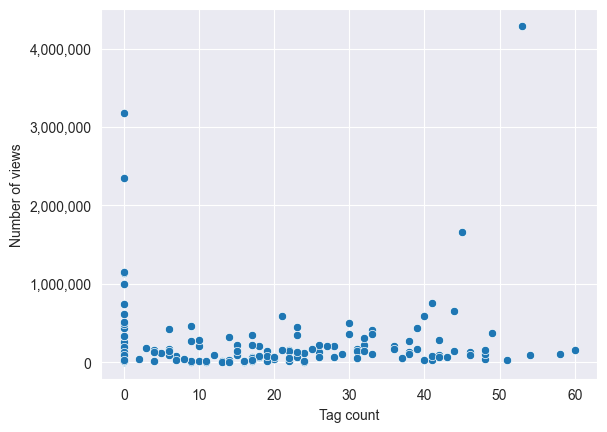

In [66]:
# fashion video 
ax = sns.scatterplot(data = fashion_video_df, x = "tagCount", y = "viewCount")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.set(xlabel='Tag count', ylabel='Number of views')
plt.show()

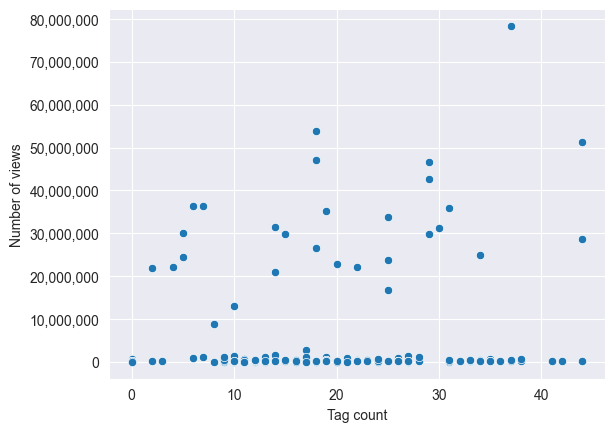

In [67]:
# history vidoes
ax = sns.scatterplot(data = history_video_df, x = "tagCount", y = "viewCount")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.set(xlabel='Tag count', ylabel='Number of views')
plt.show()

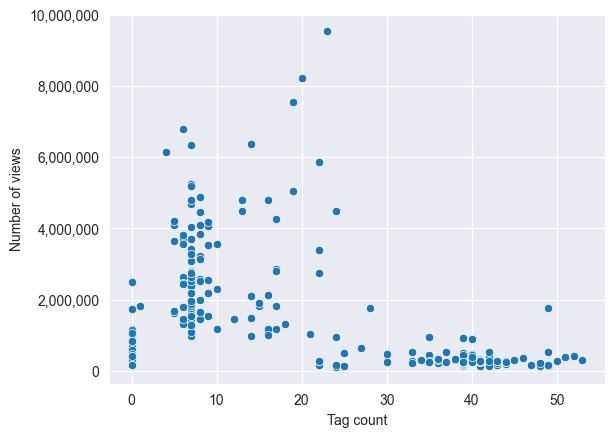

In [68]:
#travelling 
ax = sns.scatterplot(data = travelling_video_df, x = "tagCount", y = "viewCount")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.set(xlabel='Tag count', ylabel='Number of views')
plt.show()

It can be observed in all of the plots above that there is no particular correlation between the tag count and the number of views. 

#### Does the title length matter for a video to get more views?

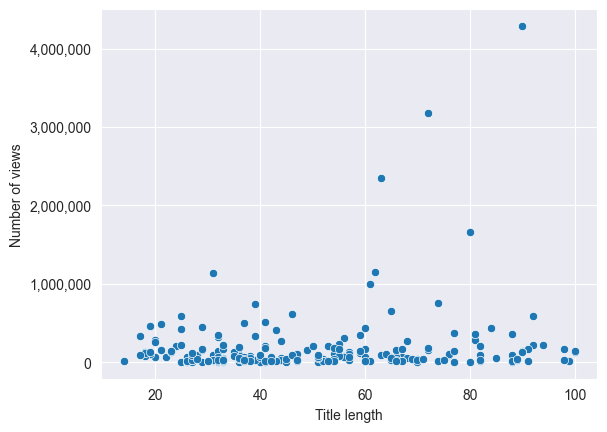

In [69]:
# fashion videos 
ax = sns.scatterplot(data = fashion_video_df, x = "titleLength", y = "viewCount")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.set(xlabel='Title length', ylabel='Number of views')
plt.show()

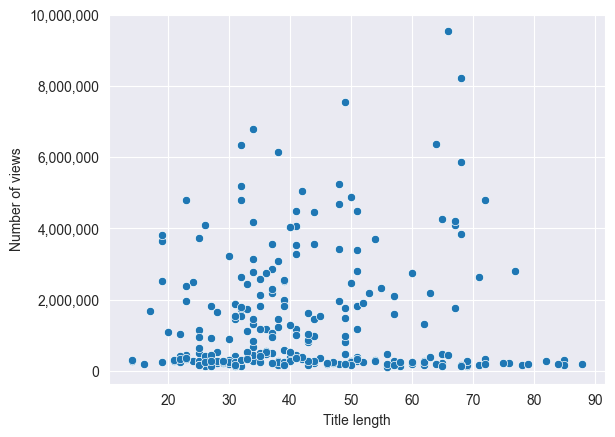

In [70]:
# history videos 
ax = sns.scatterplot(data = travelling_video_df, x = "titleLength", y = "viewCount")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.set(xlabel='Title length', ylabel='Number of views')
plt.show()

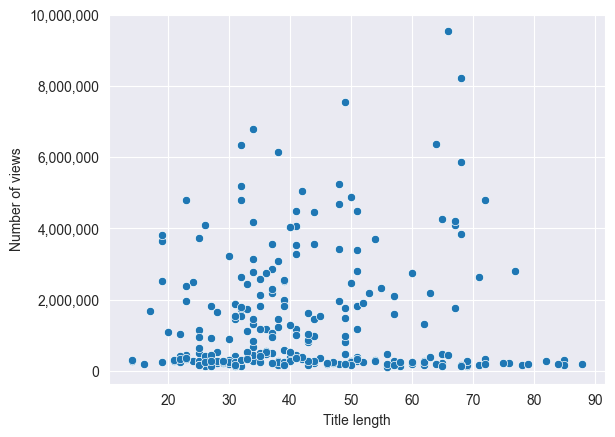

In [71]:
# travelling videos 
ax = sns.scatterplot(data = travelling_video_df, x = "titleLength", y = "viewCount")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.set(xlabel='Title length', ylabel='Number of views')
plt.show()

The title length does not correlate with the number of views. 

#### Does duration of a video matter for the video to get more views?

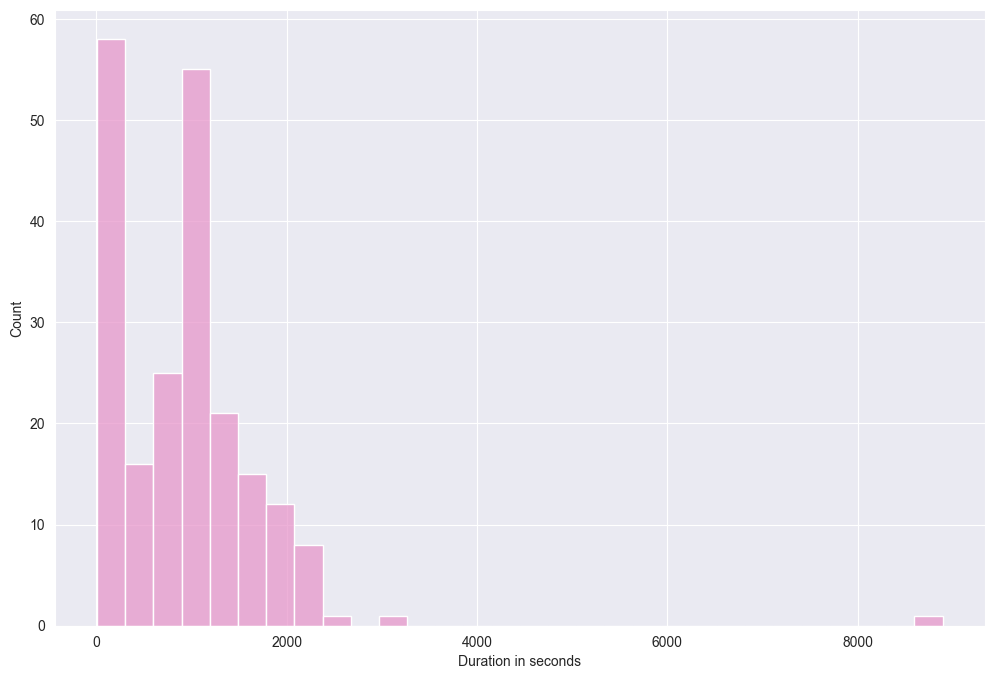

In [72]:
#fashion videos 
plt.figure(figsize=(12,8))
ax = sns.histplot(data=fashion_video_df[fashion_video_df['durationSec'] < 10000], x="durationSec", bins=30,color='#E797cb')
ax.set(xlabel='Duration in seconds', ylabel='Count')
plt.show()

It can be seen in the plot above that most videos are 300 to 1200/1300 seconds (5 to 20 minutes) long. I took into consideration streaming videos, which may happen to be really long, which is why I decided to limit the duration of the videos to 10000 seconds. 

Let's check the relationship between duration of a video and comment and like counts. 

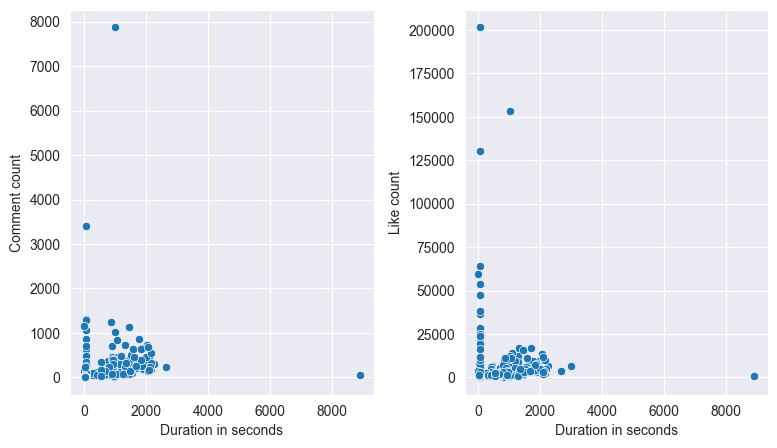

In [73]:
# likes and comments per duration
fig, ax = plt.subplots(1,2,figsize=(9,5))
sns.scatterplot(data = fashion_video_df, x = "durationSec", y = "commentCount", ax=ax[0])
ax[0].set(xlabel='Duration in seconds', ylabel='Comment count')

sns.scatterplot(data = fashion_video_df, x = "durationSec", y = "likeCount", ax=ax[1])
ax[1].set(xlabel='Duration in seconds', ylabel='Like count')

fig.subplots_adjust(wspace=0.3)

In this case with using fashion related videos, there is no correlation between the duration of a video and the number of views. 

I will repeat the process of creating the same plots for history and travelling data sets.

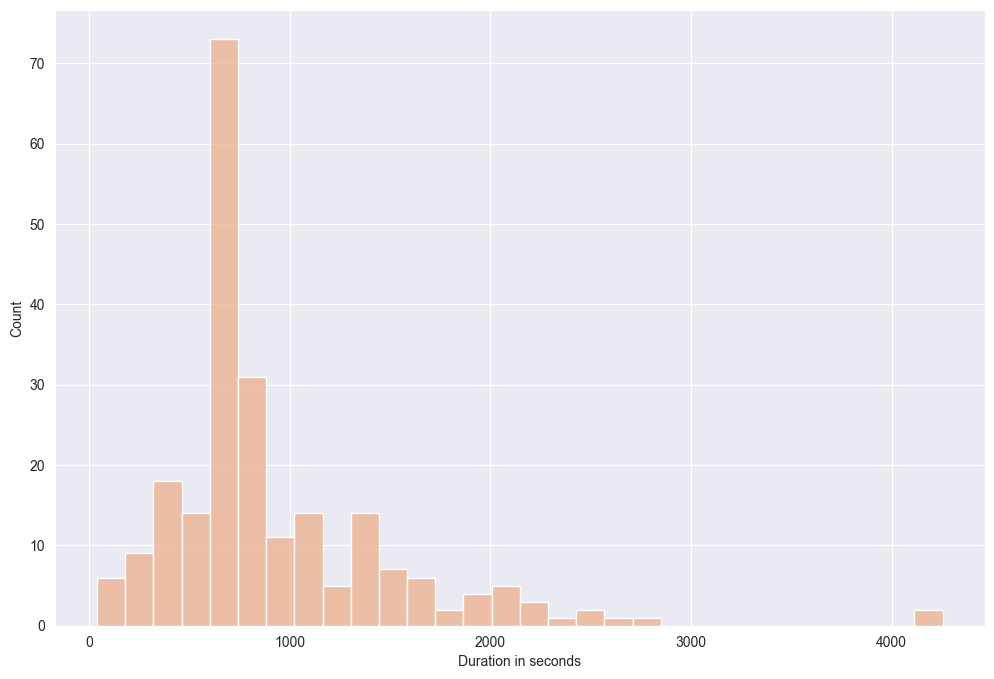

In [74]:
# history videos 
plt.figure(figsize=(12,8))
ax = sns.histplot(data=history_video_df[history_video_df['durationSec'] < 10000], x="durationSec", bins=30,color='#Edb08d')
ax.set(xlabel='Duration in seconds', ylabel='Count')
plt.show()

Here, it is clear that most vidoes are 600/700 seconds long, which is equal to 10/11 minutes.

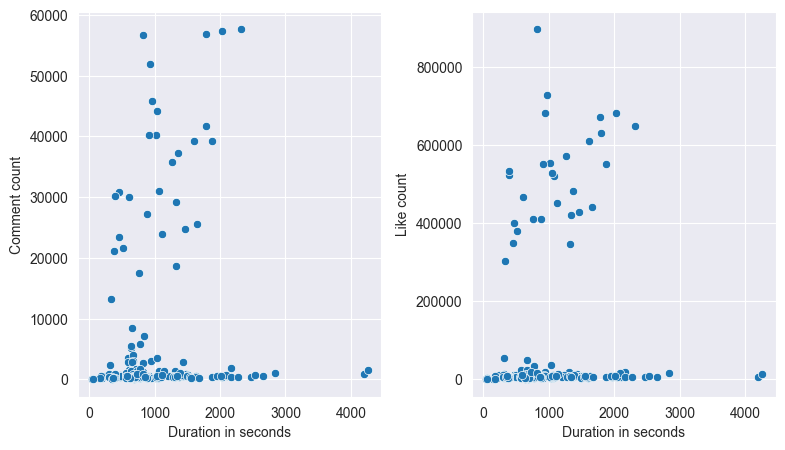

In [75]:
fig, ax = plt.subplots(1,2,figsize=(9,5))
sns.scatterplot(data = history_video_df, x = "durationSec", y = "commentCount", ax=ax[0])
ax[0].set(xlabel='Duration in seconds', ylabel='Comment count')

sns.scatterplot(data = history_video_df, x = "durationSec", y = "likeCount", ax=ax[1])
ax[1].set(xlabel='Duration in seconds', ylabel='Like count')

fig.subplots_adjust(wspace=0.3)

Here, the correlation is really slight but only to some extend: after crossing the point of 2500 seconds (around 42 minutes), the correlations seems to disappear. 

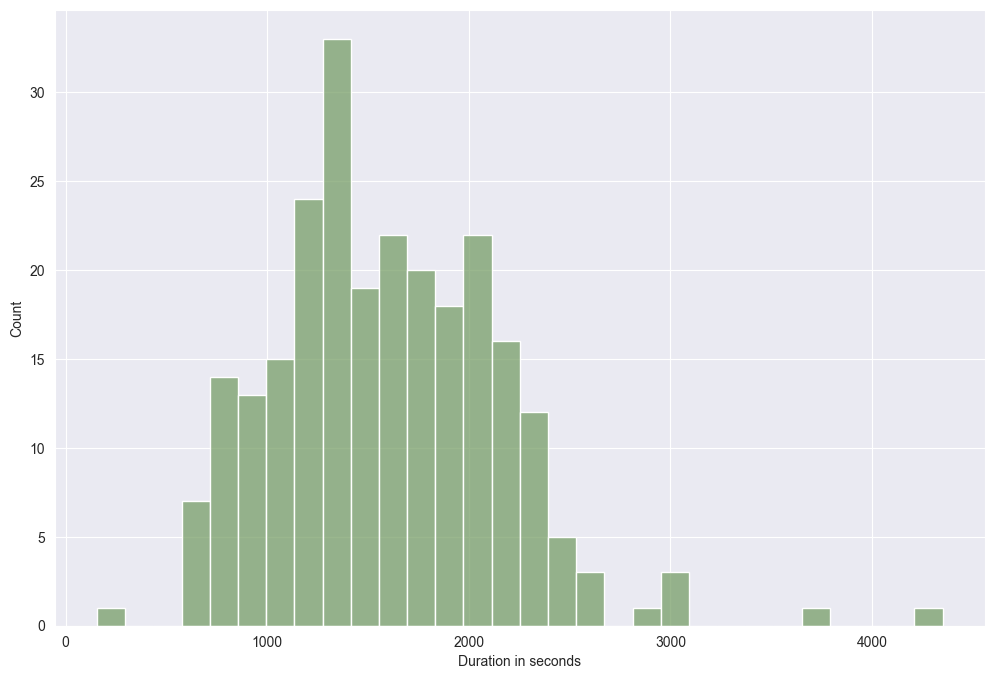

In [76]:
#travelling videos 
plt.figure(figsize=(12,8))
ax = sns.histplot(data=travelling_video_df[travelling_video_df['durationSec'] < 10000], x="durationSec", bins=30,color='#789f69')
ax.set(xlabel='Duration in seconds', ylabel='Count')
plt.show()

Travelling videos are usually way longer than fashion or history videos. There is a lot of videos withing range 800 to 2500 seconds (13 to 42 minutes). 

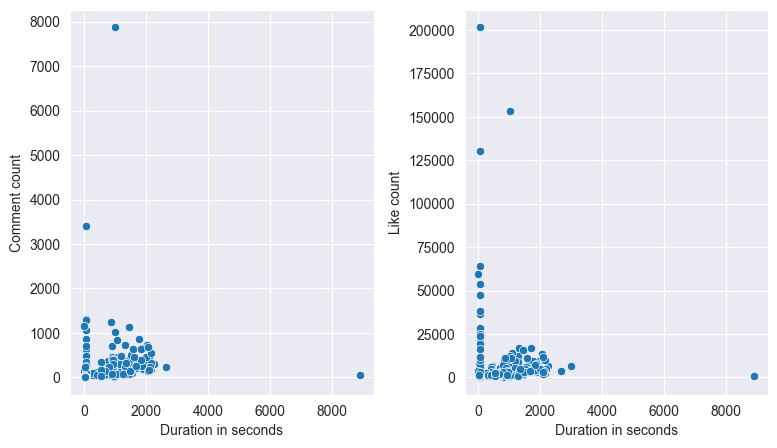

In [77]:
fig, ax = plt.subplots(1,2,figsize=(9,5))
sns.scatterplot(data = fashion_video_df, x = "durationSec", y = "commentCount", ax=ax[0])
ax[0].set(xlabel='Duration in seconds', ylabel='Comment count')

sns.scatterplot(data = fashion_video_df, x = "durationSec", y = "likeCount", ax=ax[1])
ax[1].set(xlabel='Duration in seconds', ylabel='Like count')

fig.subplots_adjust(wspace=0.3)

However, the correlation in this case does not exists. 

#### Does the day of the week matter for a video to get more views?

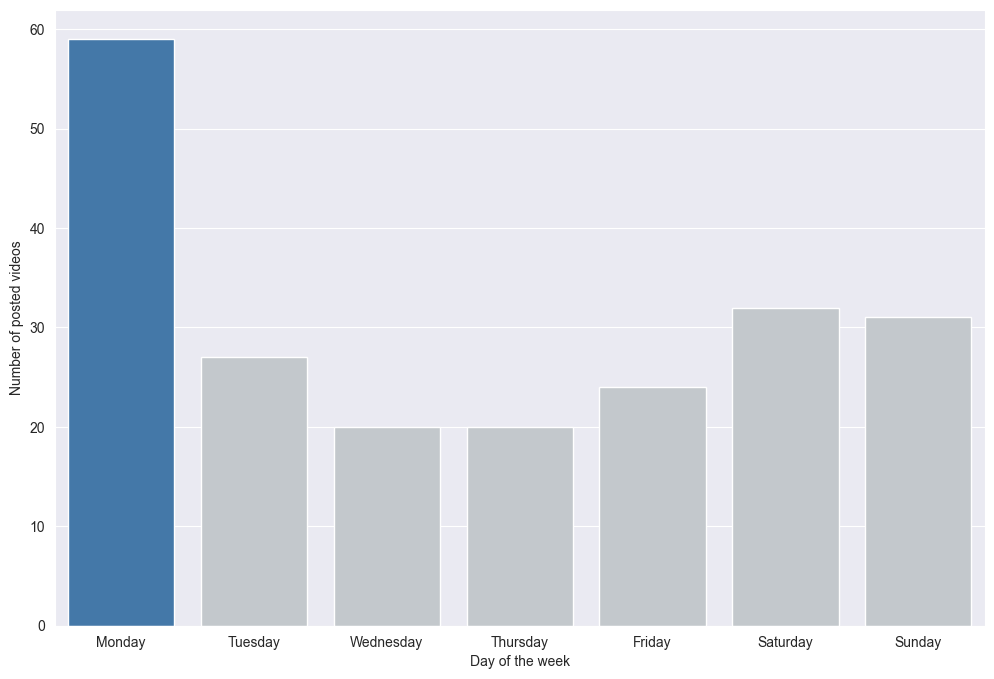

In [78]:
#checking on which day videos are mainly posted - fashion channels 
fashion_day_df = pd.DataFrame(fashion_video_df['publishedDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fashion_day_df = fashion_day_df.reindex(weekdays)
cols = ['#C1c8ce' if (x < fashion_day_df['publishedDayName'].max()) else '#3379b9' for x in fashion_day_df['publishedDayName']]
plt.figure(figsize=(12,8))
ax = sns.barplot(x=fashion_day_df.index,y='publishedDayName',data=fashion_day_df,palette=cols)
ax.set(xlabel='Day of the week', ylabel='Number of posted videos')
plt.show()

It is easy to notice that most of the videos in the fashion niche were posted on mondays. 

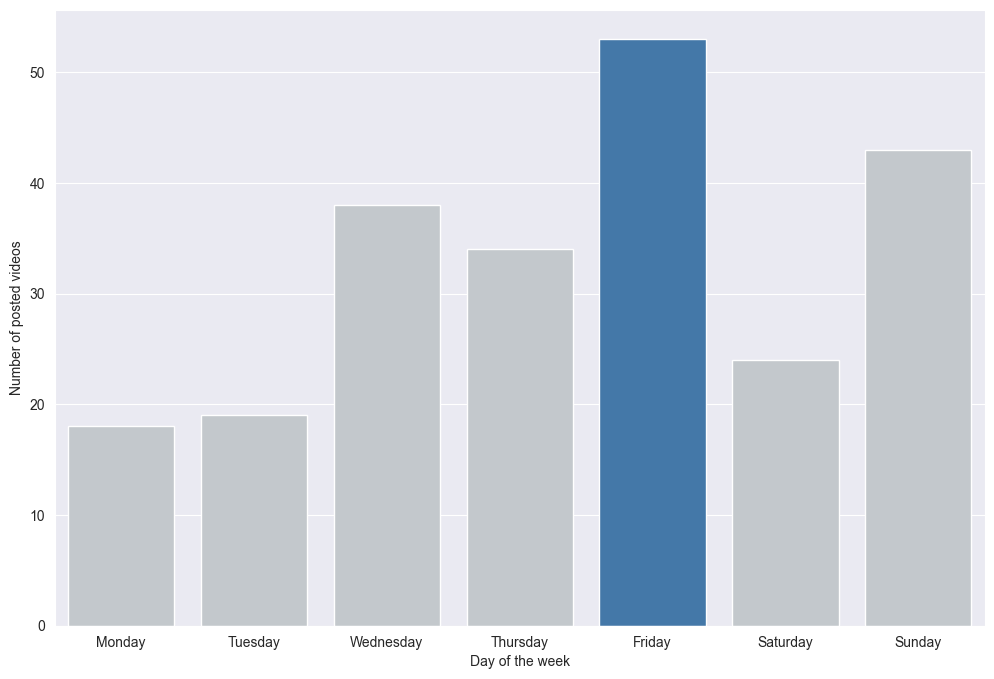

In [79]:
#history channels 
history_day_df = pd.DataFrame(history_video_df['publishedDayName'].value_counts())
history_day_df = history_day_df.reindex(weekdays)
cols = ['#C1c8ce' if (x < history_day_df['publishedDayName'].max()) else '#3379b9' for x in history_day_df['publishedDayName']]
plt.figure(figsize=(12,8))
ax = sns.barplot(x=history_day_df.index,y='publishedDayName',data=history_day_df,palette=cols)
ax.set(xlabel='Day of the week', ylabel='Number of posted videos')
plt.show()

In history related videos niche, the day on which most of the videos were posted is Friday. 

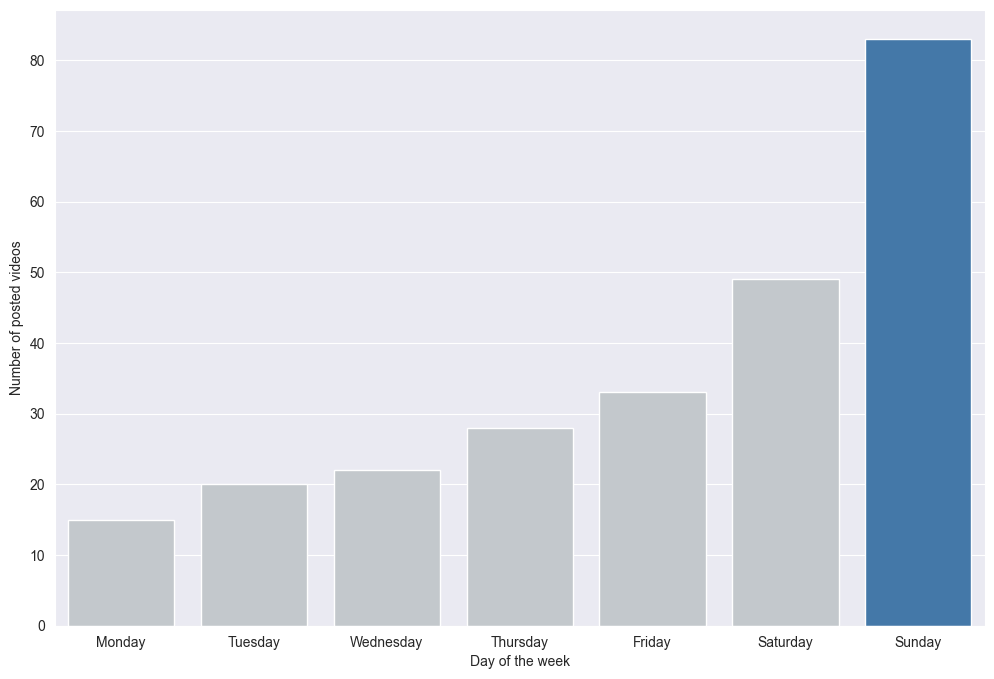

In [80]:
#travelling channels 
travelling_day_df = pd.DataFrame(travelling_video_df['publishedDayName'].value_counts())
travelling_day_df = travelling_day_df.reindex(weekdays)
cols = ['#C1c8ce' if (x < travelling_day_df['publishedDayName'].max()) else '#3379b9' for x in travelling_day_df['publishedDayName']]
plt.figure(figsize=(12,8))
ax = sns.barplot(x=travelling_day_df.index,y='publishedDayName',data=travelling_day_df,palette=cols)
ax.set(xlabel='Day of the week', ylabel='Number of posted videos')
plt.show()

Most travelling videos were posted on Sunday. One can observe that there is a continuously growing number of posted videos day after another. 

#### Does the hour on which a video was posted matter for the video to get more views?

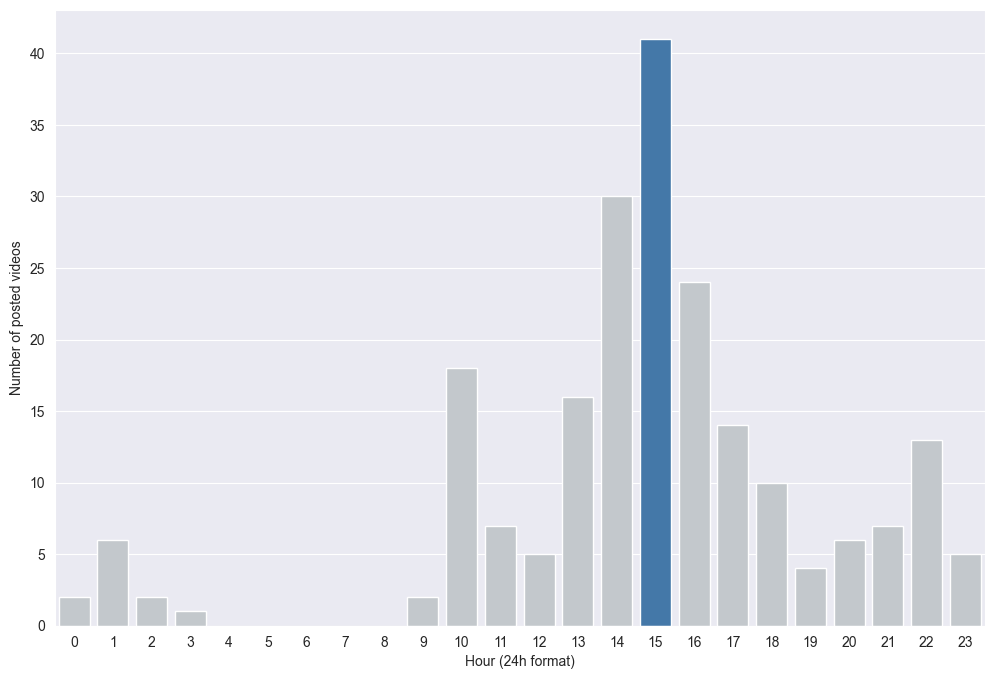

In [81]:
# fashion videos 
fashion_hour_df = pd.DataFrame(fashion_video_df['publishedHour'].value_counts())
new_index = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
fashion_hour_df = fashion_hour_df.reindex(new_index)
plt.figure(figsize=(12,8))
columns = ['#C1c8ce' if (x < fashion_hour_df['publishedHour'].max()) else '#3379b9' for x in fashion_hour_df['publishedHour']]
ax = sns.barplot(x=fashion_hour_df.index,y='publishedHour',data=fashion_hour_df,palette=columns)
ax.set(xlabel='Hour (24h format)', ylabel='Number of posted videos')
plt.show()

Most of the videos were posted between 14 and 16 o'clock (2PM and 4PM). 

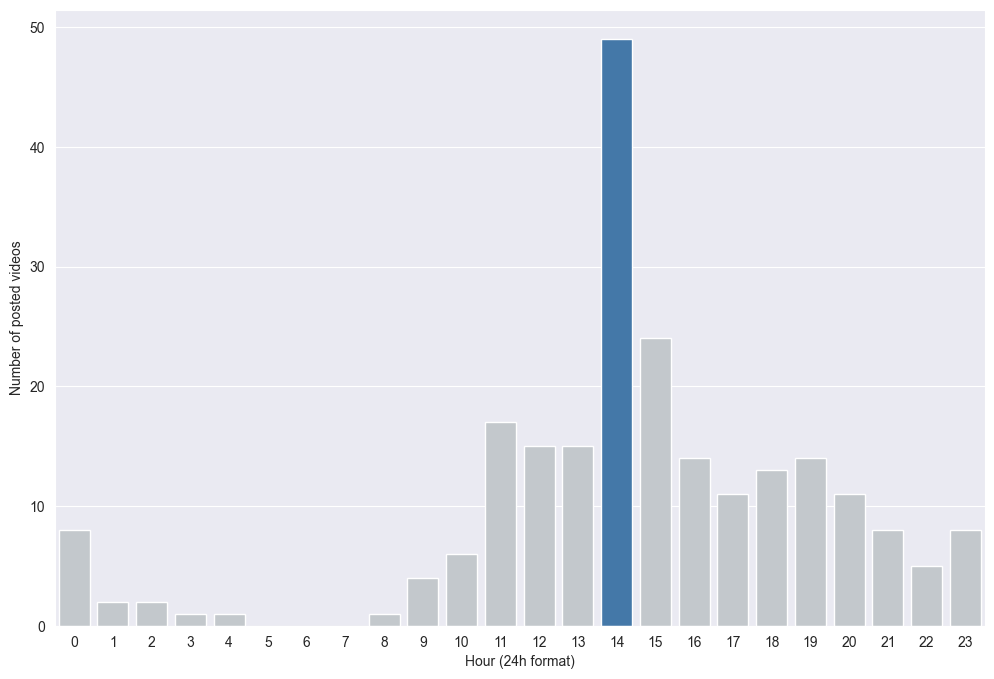

In [82]:
# history 
history_hour_df = pd.DataFrame(history_video_df['publishedHour'].value_counts())
history_hour_df = history_hour_df.reindex(new_index)
plt.figure(figsize=(12,8))
columns = ['#C1c8ce' if (x < history_hour_df['publishedHour'].max()) else '#3379b9' for x in history_hour_df['publishedHour']]
ax = sns.barplot(x=history_hour_df.index,y='publishedHour',data=history_hour_df,palette=columns)
ax.set(xlabel='Hour (24h format)', ylabel='Number of posted videos')
plt.show()

Here, way more videos were posted at 14 o'clock (2PM) than at another hours. Some videos were posted at 15(3PM), some other at 11(AM).

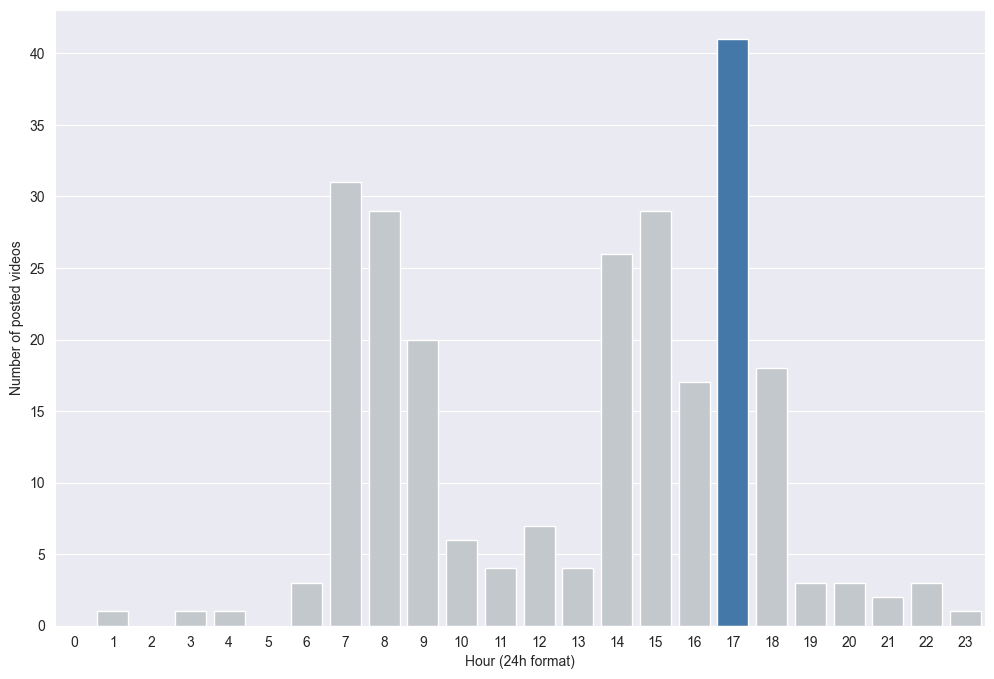

In [83]:
# travelling
travelling_hour_df = pd.DataFrame(travelling_video_df['publishedHour'].value_counts())
travelling_hour_df = travelling_hour_df.reindex(new_index)
plt.figure(figsize=(12,8))
columns = ['#C1c8ce' if (x < travelling_hour_df['publishedHour'].max()) else '#3379b9' for x in travelling_hour_df['publishedHour']]
ax = sns.barplot(x=travelling_hour_df.index,y='publishedHour',data=travelling_hour_df,palette=columns)
ax.set(xlabel='Hour (24h format)', ylabel='Number of posted videos')
plt.show()

It can be that there is a trend that most of the videos were posted during the afternoon hours (14-17 or 2PM-5PM) as well as early in the morning(7-9PM). 

## Conclusions:
This project was focused on getting information about fashion, history and travelling channels on youtube.
By exploring all video data sets from each field I made some obervations:
- there is a correlation between likes, comments and view count in each field. It is not surprising that the more popular the video is, the more likes and comments it can get. It can also reach broader audience. 
- tag count does not matter for a video to get more views. Most videos have around 8 to 30 tags. 
- title length also does not help a video to get more likes
- there is no relationship between duration of a video and the number of views it gets. 
- depending on the field, most videos were uploaded on Mondays, Friday and Sundays, usually during the afternoon hours. 

Limitation of the project:
- data sets are really small (all of them are in the range 200-250 videos in the moment of publishing this notebook)
- In this project, I took into consideration only 5 channels from each niche which I like to watch in my spare time. 

Ideas for the next project:
- get comments from each video and explore them
- include more channels, also smaller ones 
- compare other niches f.e music, beauty, architecture
- compare niches based on the country 

## References: 

1. Youtube API guide: https://developers.google.com/youtube/v3
2. Convert Youtube video duration to time function: https://stackoverflow.com/questions/15596753/how-do-i-get-video-durations-with-youtube-api-version-3
3. Format the numbers on y axis: https://stackoverflow.com/questions/53747298/how-to-format-seaborn-matplotlib-axis-tick-labels-from-number-to-thousands-or-mi
4. Rotate the names on x axis: https://stackoverflow.com/questions/26540035/rotate-label-text-in-seaborn-factorplot
5. Highlight maximum value in bar plot: https://stackoverflow.com/questions/31074758/how-to-set-a-different-color-to-the-largest-bar-in-a-seaborn-barplot